<a href="https://githubtocolab.com/Eunseob/purdue_me597/blob/main/lab/lab8/L8_Colab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 8.2 Machine Learning 2 – Artificial Neural Network, Classification 

# Training ML model for anomaly detection

Now, you are ready to train ML model. Follow the steps below to create your autoencoder model to predict the anomalous condition of the AFF. In this lab manual, we will use this Colab Notebook. But, you can use this Colab Notefile (ipynb) on your computer using Jupyter Notebook or creating a Python script. Note that if you train the model on your laptop, make sure that TensorFlow 2.2 must be used because of the compatibility with Raspberry Pi.

We will reuse the autoencoder training code in [Prelab8.2](https://githubtocolab.com/Eunseob/purdue_me597/blob/main/lab/lab8/PL8_Colab2.ipynb).

**When you first train the model, please use the given axis, feature, and hyper -parameters to perform Task 2.2. And then, try different combinations.**

### Install TensorFlow 2.2.0 and import relevant Python packages on your Colab session 

In [ ]:
!pip install tensorflow==2.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.0/26.0 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.6/454.6 KB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.9/152.9 KB 4.5 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully unin

In [ ]:
# Let's check the installed tensorflow version
# The output must be 'TensorFlow Version is 2.2.0'
import tensorflow as tf

print('TensorFlow Version is', tf.__version__)

TensorFlow Version is 2.2.0


In [ ]:
import os
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
from tensorflow import keras
from scipy import stats, fft

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

### Load data

First, upload your training data (Normal and Abnormal) which you collected on the last part to this Colab session.

  * Method 1: Upload file on this Colab session (Fast)
  * Method 2: Use the code block below (Slow)
  * Method 3: Mount your Google Drive if your data is in it (Fast)

In [ ]:
#This code allows you to upload a file from your local drive
from google.colab import files
uploaded = files.upload()

Saving 20230219_225959_Normal_lab8_data.csv to 20230219_225959_Normal_lab8_data (1).csv
Saving 20230219_230948_Abnormal_lab8_data.csv to 20230219_230948_Abnormal_lab8_data (1).csv


In [ ]:
## Loading data using pandas

normal_data_file = "20230219_225959_Normal_lab8_data.csv" # normal condition filename: You much change this!
abnormal_data_file = "20230219_230948_Abnormal_lab8_data.csv" # abnormal condition filename: You much change this!

df_normal = pd.read_csv(normal_data_file) # normal dataframe
df_abnormal = pd.read_csv(abnormal_data_file) # abnormal dataframe

frames = [df_normal, df_abnormal] # frame list to merge two dataframes into one

df = pd.concat(frames) # new concatenated dataframe

df # display dataframe


,Condition,Xacc array [m/s2],Yacc array [m/s2],Zacc array [m/s2]
0,Normal,0.0 0.0 0.8629851999999999 0.0 -0.9414384 -1.0...,1.1767979999999998 -0.784532 1.176797999999999...,8.7867584 11.2972608 10.0420096 10.0420096 9.3...
1,Normal,-1.6475172 3.7657536 -1.3337044 -2.35359599999...,-0.4707192 0.0 0.0 -1.3337044 -1.569064 0.0 0....,9.1005712 9.8851032 10.5127288 10.0420096 9.57...
2,Normal,0.6276256 0.0 0.2353596 -1.0983448 -0.5491724 ...,0.9414384 2.4320492 1.1767979999999998 -0.0784...,8.8652116 10.6696352 8.1591328 8.1591328 10.59...
3,Normal,0.8629851999999999 0.0 0.784532 -1.3337044 -0....,-0.6276256 1.4121576 1.7259703999999998 0.7845...,10.591182 8.5513988 9.1790244 8.7083052 9.2574...
4,Normal,0.5491724 1.2552512 0.0 0.0 0.5491724 0.0 0.0 ...,1.569064 -2.5889556 0.4707192 0.0 3.7657536 1....,8.394492399999999 12.8663248 8.5513988 9.41438...
...,...,...,...,...
295,Abnormal,1.2552512 2.5105024 8.1591328 4.314926 -0.9414...,-5.0210048 -5.099458 -3.8442068 -0.6276256 0.6...,9.8851032 8.9436648 11.2972608 6.3547091999999...
296,Abnormal,4.314926 0.0 3.2165812 4.9425516 -3.2165812 -1...,-5.962443199999999 -5.0210048 -7.2176943999999...,12.709418399999999 7.060788 12.003339599999999...
297,Abnormal,4.0011132 5.0210048 2.1966896 0.0 0.784532 7.5...,-3.8442068 -7.3746008 -6.903881599999999 -4.47...,8.7867584 12.552512 12.4740588 8.629852 9.3359...
298,Abnormal,0.6276256 -4.5502856 -4.158019599999999 -0.941...,-1.8044235999999998 1.569064 4.9425516 1.56906...,11.924886399999998 7.9237732 10.1204628 7.6884...


### Data Transformation

The strategy to build this model is to select, one by one, data from each axis and access which axis helps the model classify with better accuracy and precision.

Let's start with the X-axis:
Assign the X-axis on the variable AXIS on the code below.

In [ ]:
## Data Transformation
# X-axis: 'Xacc array [m/s2]'
# Y-axis: 'Yacc array [m/s2]'
# Z-axis: 'Zacc array [m/s2]'
AXIS = 'Xacc array [m/s2]' # in this case, X-axis acceleration data

# Exploding the values contained in selected column and converting the string values into float values
df_new = pd.concat([df['Condition'],df[AXIS].str.split(' ', expand=True).astype(float)], axis=1) # transform space delimited array to each value
ds = df_new.copy() # make ds by copying df

Now, we change the labels 'Normal' and 'Abnormal' into binary notation for the model usage.

In [ ]:
#Converting the Classifier into binary values
ds.loc[df['Condition'] == 'Normal', 'Status'] = 1 # if Condition column is 'Normal', Give 'Status' Column 1
ds.loc[df['Condition'] == 'Abnormal', 'Status'] = 0 # if Condition column is 'Abnormal', Give 'Status' Column 0
ds.drop('Condition', axis=1, inplace=True) # drop 'Condition' column (the first column)

ds # display ds (dataset)

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,Status
0,0.000000,0.000000,0.862985,0.000000,-0.941438,-1.098345,-0.784532,0.000000,0.470719,-0.078453,...,2.667409,0.941438,-0.706079,1.569064,-0.627626,-1.019892,1.255251,-0.784532,0.470719,1.0
1,-1.647517,3.765754,-1.333704,-2.353596,-1.333704,0.000000,-1.412158,-1.490611,0.000000,0.470719,...,-1.804424,1.804424,-1.019892,0.000000,1.412158,2.432049,0.000000,0.392266,-0.078453,1.0
2,0.627626,0.000000,0.235360,-1.098345,-0.549172,-0.078453,1.176798,1.255251,2.039783,-0.078453,...,-0.078453,0.000000,0.313813,0.000000,-1.882877,1.098345,1.255251,1.255251,-1.569064,1.0
3,0.862985,0.000000,0.784532,-1.333704,-0.862985,-0.078453,0.000000,-0.078453,0.235360,0.000000,...,0.000000,0.941438,0.549172,0.549172,0.156906,-2.432049,1.176798,0.000000,-2.745862,1.0
4,0.549172,1.255251,0.000000,0.000000,0.549172,0.000000,0.000000,0.000000,1.882877,1.569064,...,0.313813,0.470719,0.000000,1.255251,-0.156906,0.627626,1.725970,-1.255251,0.549172,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,1.255251,2.510502,8.159133,4.314926,-0.941438,-1.882877,-1.961330,-5.021005,-5.962443,-7.217694,...,-5.021005,-10.198916,-3.765754,10.355822,3.373488,5.021005,0.784532,7.531507,-4.471832,0.0
296,4.314926,0.000000,3.216581,4.942552,-3.216581,-1.569064,-8.080680,-3.844207,4.079566,3.451941,...,-4.393379,-2.039783,-4.707192,-6.668522,-6.903882,-8.237586,-10.198916,-10.198916,10.983448,0.0
297,4.001113,5.021005,2.196690,0.000000,0.784532,7.531507,6.119350,-3.138128,-4.471832,-1.333704,...,-8.159133,-3.765754,-2.588956,6.746975,10.669635,6.668522,2.510502,7.531507,5.570177,0.0
298,0.627626,-4.550286,-4.158020,-0.941438,1.255251,-6.668522,-5.021005,-10.591182,-3.922660,-5.021005,...,0.235360,-6.668522,-5.021005,-6.590069,-6.119350,-5.727084,-13.023231,8.943665,8.316039,0.0


### Training data pipe-line

We just loaded data and transformed it. Let's start creating input data pipe-line for training the model.

Define data, raw data and labels.

In [ ]:
data = ds.values
# Define Raw data W/O signal processing
raw_data = data[:,:-1]
# Labels: The last column
labels = data[:,-1]

Here is the signal processing part. Time domain and frequency domain will be used for training the model.

Using the signal processing, you can define the time domain feature and frequency domain feature, respectively.

In [ ]:
## signal processing
# Time-domain data
def timeFeatures(data):
    feature = [] # initialize feature list
    for i in range(len(data)):
        mean = np.mean(data[i]) # mean
        std = np.std(data[i]) # standard deviation
        rms = np.sqrt(np.mean(data[i] ** 2)) # root mean squre
        peak = np.max(abs(data[i])) # peak
        skew = stats.skew(data[i]) # skewness
        kurt = stats.kurtosis(data[i]) # kurtosis
        cf = peak/rms # crest factor
        # number of feature of each measurement = 7
        feature.append(np.array([mean,std,rms,peak,skew,kurt,cf], dtype=float))
    feature = np.array(feature)
    return feature # feature list, each element is numpy array with datatype float

# DFT magnitude data
def freqFeatures(data):
    feature = []
    for i in range(len(data)):
        N = len(data[i]) # number of data
        yf = 2/N*np.abs(fft.fft(data[i])[:N//2]) # yf is DFT signal magnitude
        yf[0] = 0
        feature.append(np.array(yf))
    feature = np.array(feature)
    return feature


time_data = timeFeatures(raw_data) # define time domain feature
freq_data = freqFeatures(raw_data) # define frequency domain feature (DFT)

Here is data (feature) selection and split part.

In [ ]:
## Data (feature) selection and Split training and validation dataset
# Feature selection
input_feature = raw_data # raw data input without any signal processing
# input_feature = time_data # time domain data
# input_feature = freq_data # frequency data

# get training and test (validation) dataset
train_data, test_data, train_labels, test_labels = train_test_split(
    input_feature, labels, test_size=0.2, random_state=20
)

Normalization based on a min/max scaling is done here to support the learning objective of the autoencoder (minimizing reconstruction error) and makes the results more interpretable.

In [ ]:
## Data normalization

def tensorNormalization(data): # data as numpy array
    min_val = tf.reduce_min(data) # get min val
    max_val = tf.reduce_max(data) # get max val
    data_normal = (data - min_val) / (max_val - min_val) # get normalized data as numpy array
    return tf.cast(data_normal, tf.float32) # tensorarray, float 32 datatype

train_data = tensorNormalization(train_data) # Normalizing train data
test_data = tensorNormalization(test_data) # Normalizing test data

You will train the autoencoder using only the normal rhythms, which are labeled in the dataset as 1. Separate the normal vibrations from the abnormal vibrations. **You have to make sure of the size/dimension of feature array.**

In [ ]:
#Splitting the dataset based on classification: train_labels: Normal, ~train_labels: Abnormal
train_labels = train_labels.astype(bool) # transform labels as bool (True or False)
test_labels = test_labels.astype(bool) # in case of 'Normal' it is Ture, if not, False

normal_train_data = train_data[train_labels] # define normal train data
normal_test_data = test_data[test_labels] # define normal test data

anomalous_train_data = train_data[~train_labels] # define abnormal train data
anomalous_test_data = test_data[~test_labels] # define abnormal test data

portion_of_anomaly_in_training = 0.1 #10% of training data will be anomalies
end_size = int(len(normal_train_data)/(10-portion_of_anomaly_in_training*10))
combined_train_data = np.append(normal_train_data, anomalous_test_data[:end_size], axis=0)
N_feature = combined_train_data.shape[1] # get the Number of feature, it depends on your input feature!
print("Number of training dataset is {}.".format(combined_train_data.shape))
print("Number of feature is {}.".format(N_feature)) 

Number of training dataset is (260, 1000).
Number of feature is 1000.


Plot a normal vibration feature

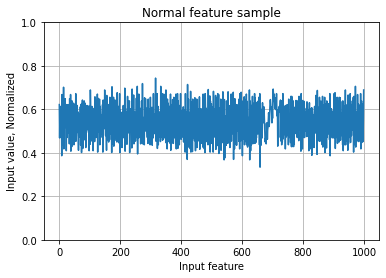

In [ ]:
#Plotting sample of normal data
plt.grid()
plt.plot(np.arange(N_feature), normal_train_data[0])
plt.title("Normal feature sample")
plt.ylim([0, 1])
plt.xlabel("Input feature")
plt.ylabel("Input value, Normalized")
plt.show()

Plot a abnomalous vibration feature

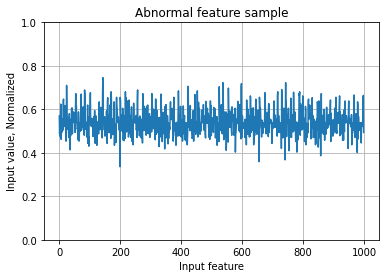

In [ ]:
#Plotting sample of anomalous data
plt.grid()
plt.plot(np.arange(N_feature), anomalous_train_data[0])
plt.title("Abnormal feature sample")
plt.ylim([0, 1])
plt.xlabel("Input feature")
plt.ylabel("Input value, Normalized")
plt.show()

### Task 2.1

What differences do you notice between the normal and anomalous plots? Can you figure out anomaly based on the siganl/feature?



---

Write down your answer to Task 2.1 here.

---



### Autoencoder model training

Changing the size of the embedding (latent space) can produce interesting results. Try to play around with that layer size by assigning a value to the variable EMBEDDING_SIZE.

In [ ]:
## Creating the artificial neural network using autoencoder
EMBEDDING_SIZE = 64 #Define how many neurons in the inner layer   <-----------------------------------------------------------------------------
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(256, activation="relu"),
      layers.Dense(128, activation="relu"),
      layers.Dense(EMBEDDING_SIZE, activation="relu")]) # Smallest Layer Defined Here
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(128, activation="relu"),
      layers.Dense(256, activation="relu"),
      layers.Dense(N_feature, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector() # define autoencoder model class
print("Chosen Embedding Size: ", EMBEDDING_SIZE)
# opt = keras.optimizers.Adam(learning_rate=0.0001) # default learning rate is 0.001, if you want, you can change learning rate.
# autoencoder.compile(optimizer=opt, loss='mae')
autoencoder.compile(optimizer='adam', loss='mae')

Chosen Embedding Size:  64


### Training the model

Note that the autoencoder is trained using only the normal data, but is evaluated using the full test set.

In [ ]:
#Training the model
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=100, 
          batch_size=100,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/100
3/3 [==============================] - 1s 400ms/step - loss: 0.0520 - val_loss: 0.0812
Epoch 2/100
3/3 [==============================] - 0s 64ms/step - loss: 0.0458 - val_loss: 0.0705
Epoch 3/100
3/3 [==============================] - 0s 50ms/step - loss: 0.0403 - val_loss: 0.0666
Epoch 4/100
3/3 [==============================] - 0s 57ms/step - loss: 0.0375 - val_loss: 0.0644
Epoch 5/100
3/3 [==============================] - 0s 67ms/step - loss: 0.0367 - val_loss: 0.0638
Epoch 6/100
3/3 [==============================] - 0s 79ms/step - loss: 0.0364 - val_loss: 0.0635
Epoch 7/100
3/3 [==============================] - 0s 60ms/step - loss: 0.0363 - val_loss: 0.0628
Epoch 8/100
3/3 [==============================] - 0s 77ms/step - loss: 0.0362 - val_loss: 0.0639
Epoch 9/100
3/3 [==============================] - 0s 75ms/step - loss: 0.0360 - val_loss: 0.0645
Epoch 10/100
3/3 [==============================] - 0s 77ms/step - loss: 0.0360 - val_loss: 0.0648
Epoch 11/100
3/3 [

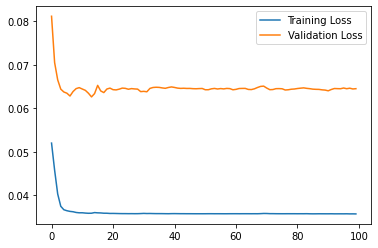

In [ ]:
#Plotting the evolution of training and validation loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

### Evaluation and determination of threshold

The Receiver Operating Characteristic (ROC) plots allows us to visualize the tradeoff between predicting anomalies as normal (false positives) and predicting normal data as an anomaly (false negative). Normal vibrations are labeled as 1 in this dataset but we have to flip them here to match the ROC curves expectations.

The ROC plot now has threshold values plotted on their corresponding points on the curve to aid in selecting a theshold for the application.

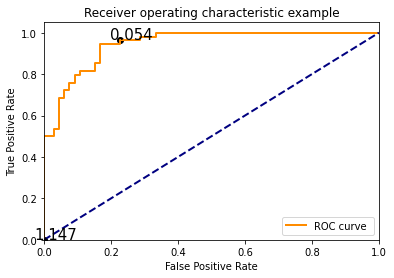

In [ ]:
#Plotting True positive and false positive rate assessment
reconstructions = autoencoder(test_data)
loss = tf.keras.losses.mae(reconstructions, test_data)
fpr = []
tpr = []
#the test labels are flipped to match how the roc_curve function expects them.
# flipped_labels = 1-test_labels
flipped_labels = 1-test_labels
fpr, tpr, thresholds = roc_curve(flipped_labels, loss)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

# plot some thresholds
thresholds_every=20
thresholdsLength = len(thresholds)
colorMap=plt.get_cmap('jet', thresholdsLength)
for i in range(0, thresholdsLength, thresholds_every):
  threshold_value_with_max_four_decimals = str(thresholds[i])[:5]
  plt.scatter(fpr[i], tpr[i], c='black')
  plt.text(fpr[i] - 0.03, tpr[i] + 0.005, threshold_value_with_max_four_decimals, fontdict={'size': 15})

plt.show()

In [ ]:
roc_auc = auc(fpr, tpr) # check roc auc score (the area of roc graph above)
print("ROC - AUC score is {}.".format(roc_auc))

ROC - AUC score is 0.9450056116722785.


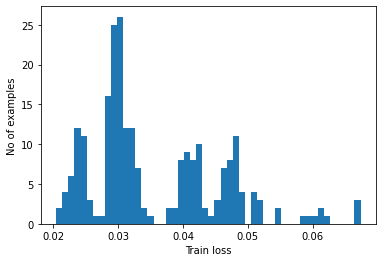

In [ ]:
## reconstructions and histogram of training model
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
## Determining the threshold to detect anomalies
# threshold =  #If you want to assign a value labeled in black in the ROC graph  <-----------------------------------------------------------------------------
threshold = np.mean(train_loss) + np.std(train_loss) # Common rule of thumb based on the histogram of the train loss
print("Threshold: ", threshold) # You have to note the threshold you will use

def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold), loss

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

preds, scores = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Threshold:  0.045758285
Accuracy = 0.725
Precision = 1.0
Recall = 0.5


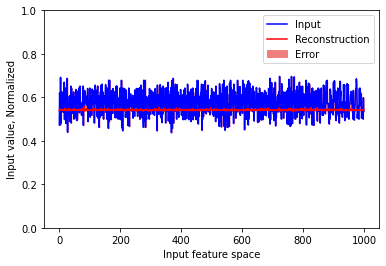

In [ ]:
# Plot "Normal" test data sample with reconstruction based on created model and error
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(N_feature), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.ylim([0, 1])
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.xlabel("Input feature space")
plt.ylabel("Input value, Normalized")
plt.show()

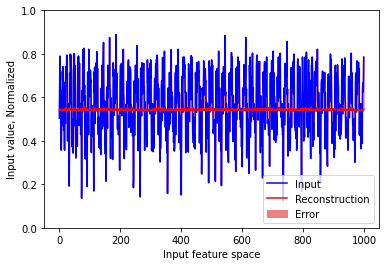

In [ ]:
# Plot "Abnormal" test data sample with reconstruction based on created model and error
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(N_feature), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.ylim([0, 1])
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.xlabel("Input feature space")
plt.ylabel("Input value, Normalized")
plt.show()

### Task 2.2

After finishing training the model so far in the condition below, answer the following questions.

  *   Acceleration axis: X-axis
  *   input feature: Raw data (without signal processing as Prelab8)
  *   Embedding size: 64
  *   Please specify if you change any hyper-parameters or variables.


1. What is performance of the model? Evaluate and analyze your model including Thresdhold, Accuracy, Precision, Recall, and so on. How did you determine the threshold?




---

Write down your answer here for Task 2.2, 1.

---



2. Do you think your model is good enough for anomaly detection of the AFF?



---

Write down your answer here for Task 2.2, 2.

---



### Save the model and reload it

After you train a model, you should save the model for implementation in the future. 

In [ ]:
# create the "models" folder first
model_folder = "models"
if not os.path.exists(model_folder):
  os.mkdir(model_folder)

t = datetime.datetime.now().strftime("%Y%m%d_%H%M%S") # define the time model saved
model_identifier = "_lab8_anomaly_x-axis_raw" # model identifier, if you want to make identifier to tell models, please change this.

export_path = "./models/"+t+model_identifier # export path


autoencoder.compute_output_shape(input_shape=(None, N_feature)) # The model cannot be saved without output shape, 
autoencoder.save(export_path) # model will be saved in "export path"


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


After you save the model, you see the created model directory under 'models/' in your Colab session as in the example below. 

<img src="https://github.com/Eunseob/purdue_me597/blob/main/lab/img/lab8_img1.png?raw=true" width="50%">


**If you run this Colab Notebook by mounting your Google Drive OR you run this on your laptop, you can skip this.**

Please note that if you want to reuse the saved model on different computer/platform, **YOU HAVE TO DOWNLOAD IT TO YOUR COMPUTER BEFORE YOU CLOSE THIS COLAB SESSION.** After you close/disconnect this Colab session, the saved model will be disappeared. Run the next code block to download the saved model as a zip file. 

In [ ]:
## First create a zip file for your saved model directory
## Note that your directory name must be different.
## after -r, the first arg. is the zip file, the second arg. is the target directory 
!zip -r /content/20230223_065122_lab8_anomaly_x-axis_raw.zip /content/models/20230223_065122_lab8_anomaly_x-axis_raw/

  adding: content/models/20230223_065122_lab8_anomaly_x-axis_raw/ (stored 0%)
  adding: content/models/20230223_065122_lab8_anomaly_x-axis_raw/saved_model.pb (deflated 91%)
  adding: content/models/20230223_065122_lab8_anomaly_x-axis_raw/assets/ (stored 0%)
  adding: content/models/20230223_065122_lab8_anomaly_x-axis_raw/variables/ (stored 0%)
  adding: content/models/20230223_065122_lab8_anomaly_x-axis_raw/variables/variables.index (deflated 67%)
  adding: content/models/20230223_065122_lab8_anomaly_x-axis_raw/variables/variables.data-00000-of-00001 (deflated 25%)


After you run the code block above, you see the created zip file from the saved model as the capture below. Try downloading it on your laptop.

<img src="https://github.com/Eunseob/purdue_me597/blob/main/lab/img/lab8_img2.png?raw=true" width="60%">

Before we wrap up this lab, let's reload the saved model to see if it works.

In [ ]:
## reload your model
reloaded_model = tf.keras.models.load_model('/content/models/20230223_065122_lab8_anomaly_x-axis_raw')

# Test your data in the realoaded model
check_data = tensorNormalization(input_feature)
prediction = predict(reloaded_model, check_data, threshold)
print(prediction)

(<tf.Tensor: shape=(600,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, Fa

### Task 2.3

After you perform reloading the saved model and run the code block above, the 'prediction' is a tuple that has two arrays. The first is boolean array and the second is float array. Explain these two arrays. For example, what do the elements in each array mean? Are they as expected?




---

Write down your answer to Task 2.3 here.

---



### Task 2.4

Discuss how to improve the model.



---

Write down your answer to Task 2.4 here.

---



### Task 2.5

Model Unit 8 (prelab + lab) by creating a flow diagram that illustrates the logic, sequence, and processes of the unit.

---

Place URL here

---

## Lab6 Summary and Deliverables

### Deliverable 1 (Do this at home)

Using the given training Python code, find your best model for anomaly detection of the AFF. As a short report including figures, tables, equations, and so on, justify how and why the best model is selected. You have to include the following information. If you need, add code/text blocks.

*   Hyper-parameters (Embedded size, batch size, epoch, etc.)
*   Threshold of your model and how determined it
*   What axis acceleration data is the best?
*   Which feature among raw, time domain, and frequency domain is the best?
*   Size of the feature
*   What are the prediction performances (accuracy, precision, recall)?


In [ ]:
### add and use code blocks



---

Add text blocks for Deliverable 1

---



### Deliverable 2

Answer the following questions for your achievements

### Q1. Please summarize Lab8.

---

Write down A1 here.

---


### Q2. What skills did you have to develop to accomplish this project?

---

Wirte down A2 here.

---

### Q3. What aspects of this project were the most beneficial for your learning?

---

Wirte down A3 here.

---

### Q4. What challenges did you encounter in completing the project?

---

Wirte down A4 here.

---

### Q5. How did you overcome the challenges or remedy the problems encountered?

---

Wirte down A5 here.

---

<br></br>

Get back to [Lab Index Page](https://colab.research.google.com/github/Eunseob/purdue_me597/blob/main/index.ipynb)